In [1]:
import os, cv2
import torch

import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import numpy as np

users_path = os.path.join(os.getcwd(), 'users')

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [2]:
def save_user(root_path, username):
    
    save_path = os.path.join(root_path, username)
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
    
    vid = cv2.VideoCapture(0) 

    imgs = []
    while(True): 

        # Capture the video frame 
        # by frame ppppppppq
        ret, frame = vid.read() 

        # Display the resulting frame 
        cv2.imshow('frame', frame) 

        # the 'q' button is set as the 
        # quitting button you may use any 
        # desired button of your choice 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            imgs.append(frame)
            cv2.imwrite(os.path.join(save_path, '{0}.png'.format(len(imgs))), frame)
            print('{0} frames capturados'.format(len(imgs)))
            
            if len(imgs) == 10: break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    # After the loop release the cap object 
    vid.release() 
    # Destroy all the windows 
    cv2.destroyAllWindows() 
    
save_user(users_path, 'mila')

1 frames capturados


# Baixe o modelo treinado para reconhecimento de faces
Demora um pouco, mas vai!

In [3]:
import requests

if not os.path.isfile('resnet50_ft_dag.pth'):
    weights_path = 'http://www.robots.ox.ac.uk/~albanie/models/pytorch-mcn/resnet50_ft_dag.pth'
    r = requests.get(weights_path, allow_redirects=True)

    open('resnet50_ft_dag.pth', 'wb').write(r.content)

In [4]:
import mtcnn
from resnet50_ft_dag import resnet50_ft_dag

detector = mtcnn.MTCNN()
model = resnet50_ft_dag('resnet50_ft_dag.pth')
print(model)

Using TensorFlow backend.


Resnet50_ft_dag(
  (conv1_7x7_s2): Conv2d(3, 64, kernel_size=[7, 7], stride=(2, 2), padding=(3, 3), bias=False)
  (conv1_7x7_s2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_relu_7x7_s2): ReLU()
  (pool1_3x3_s2): MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
  (conv2_1_1x1_reduce): Conv2d(64, 64, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_reduce_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_1x1_reduce_relu): ReLU()
  (conv2_1_3x3): Conv2d(64, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1), bias=False)
  (conv2_1_3x3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1_3x3_relu): ReLU()
  (conv2_1_1x1_increase): Conv2d(64, 256, kernel_size=[1, 1], stride=(1, 1), bias=False)
  (conv2_1_1x1_increase_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

# Guardando features e métricas de referência de cada usuária

[{'box': [324, 178, 147, 196], 'confidence': 0.9999833106994629, 'keypoints': {'left_eye': (374, 248), 'right_eye': (441, 255), 'nose': (407, 278), 'mouth_left': (373, 320), 'mouth_right': (427, 327)}}]
torch.Size([2048])


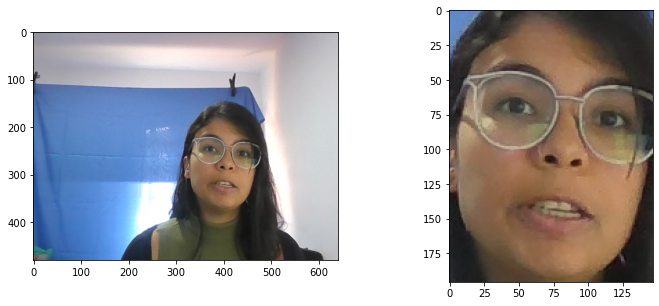

In [9]:
# Função para extração de características a partir de uma imagem
def extract_features(pixels):
    pixels = np.array(pixels, dtype=np.uint8)
    
    # Recortando a face
    faces = detector.detect_faces(pixels)
    print(faces)
    x, y, width, height = faces[0]['box']
    face = pixels[y:y+height, x:x+width]
    
    # Plot da imagem e da face recortada
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(pixels)
    axs[1].imshow(face)
    
    # extrai caracteristicas de alto nível
    face = Image.fromarray(face, 'RGB')
    face = transforms.Resize( (224, 224) )(face)
    face = transforms.ToTensor()(face).unsqueeze(0)
    
    class_, feature = model(face) 
    
    return feature.detach().cpu().data.squeeze()
    
imagem = Image.open(os.path.join(users_path, 'mila', '1.png'))
feature = extract_features(imagem)
print(feature.shape)

In [19]:
# Função para guardar as features de referência de um dado usuário

from torch import nn

metric = nn.L1Loss()

def registra_usuario(usuario):
    
    user_path = os.path.join(users_path, usuario)
    all_features = []
    for img in os.listdir(user_path):
        if img[-3:] != 'png': continue
            
        pixels = Image.open(os.path.join(user_path, img))
        feature = extract_features(pixels)
        
        all_features.append(feature)
        
    all_losses = []
    for k in range(len(all_features)):
        for j, feat in enumerate(all_features):
            if k == j: continue
            all_losses.append(metric(all_features[k], feat) )
    
    all_losses = np.asarray(all_losses)
    print(np.mean(all_losses), np.std(all_losses))
    
    all_features = np.asarray([feat.numpy() for feat in all_features])
    np.savez_compressed(os.path.join(user_path, 'referencia'), all_feats=all_features, 
                                                          mean=np.mean(all_losses),
                                                          std=np.std(all_losses))
    


Mila
[{'box': [324, 178, 147, 196], 'confidence': 0.9999833106994629, 'keypoints': {'left_eye': (374, 248), 'right_eye': (441, 255), 'nose': (407, 278), 'mouth_left': (373, 320), 'mouth_right': (427, 327)}}]
[{'box': [259, 119, 206, 295], 'confidence': 0.9999963045120239, 'keypoints': {'left_eye': (313, 229), 'right_eye': (414, 238), 'nose': (360, 299), 'mouth_left': (299, 317), 'mouth_right': (418, 326)}}]
[{'box': [275, 136, 207, 269], 'confidence': 0.9991897940635681, 'keypoints': {'left_eye': (364, 240), 'right_eye': (451, 252), 'nose': (417, 275), 'mouth_left': (364, 320), 'mouth_right': (442, 334)}}]
[{'box': [201, 121, 204, 292], 'confidence': 0.9997443556785583, 'keypoints': {'left_eye': (230, 236), 'right_eye': (316, 232), 'nose': (248, 288), 'mouth_left': (234, 339), 'mouth_right': (326, 337)}}]
[{'box': [261, 129, 218, 302], 'confidence': 0.999976634979248, 'keypoints': {'left_eye': (324, 236), 'right_eye': (424, 254), 'nose': (366, 305), 'mouth_left': (302, 330), 'mouth_rig

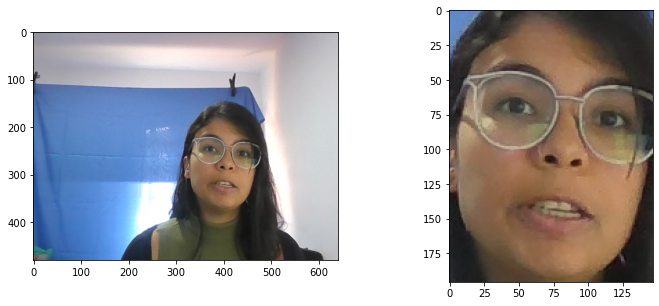

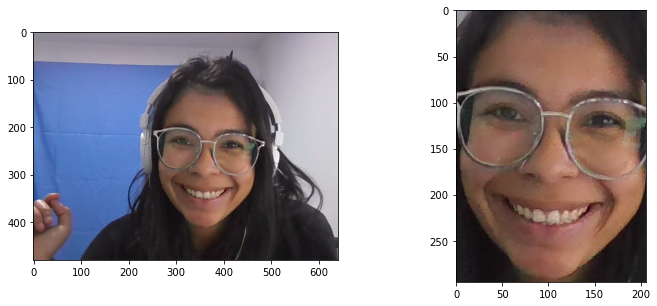

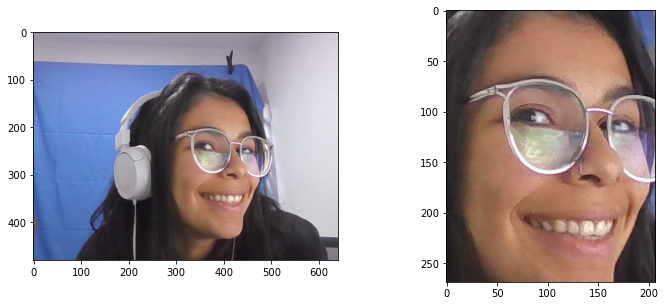

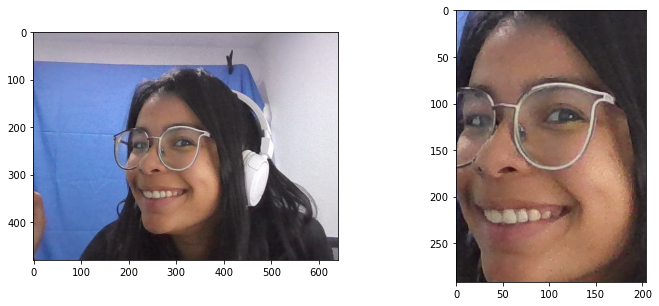

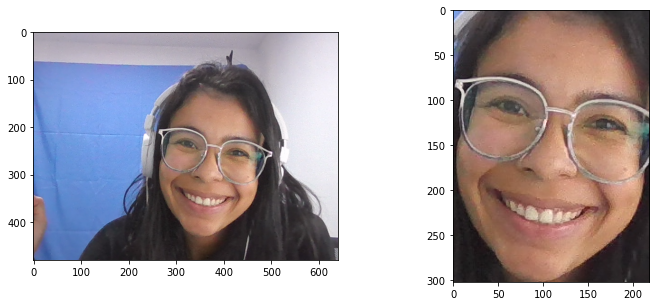

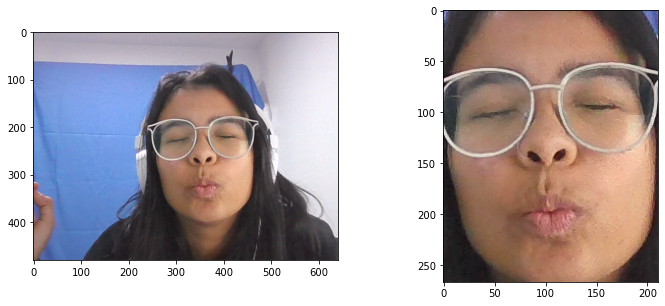

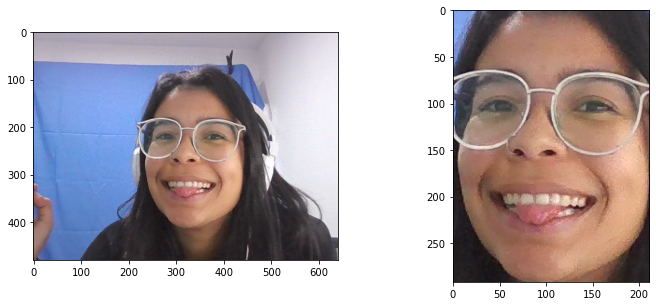

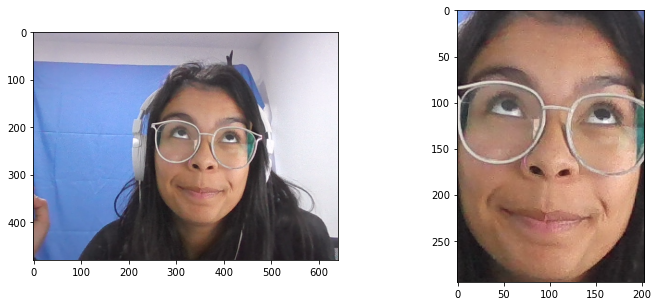

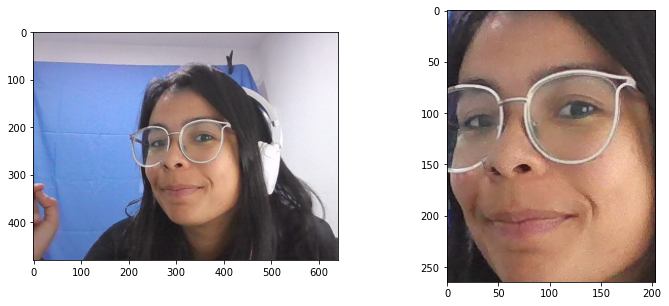

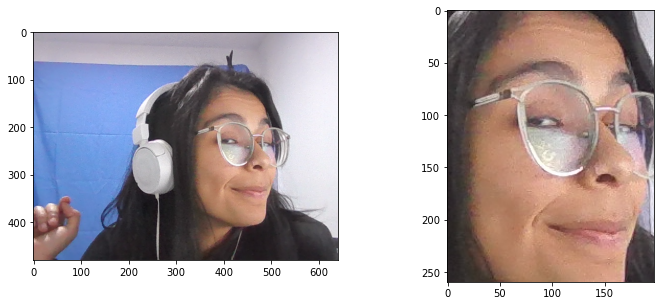

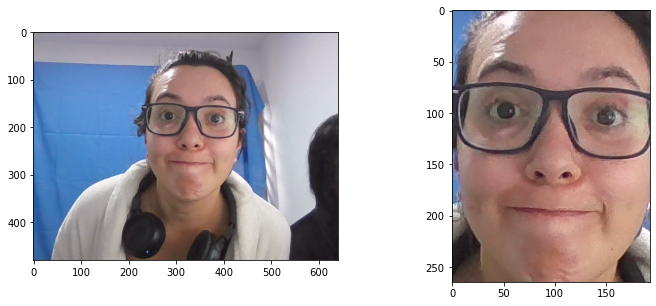

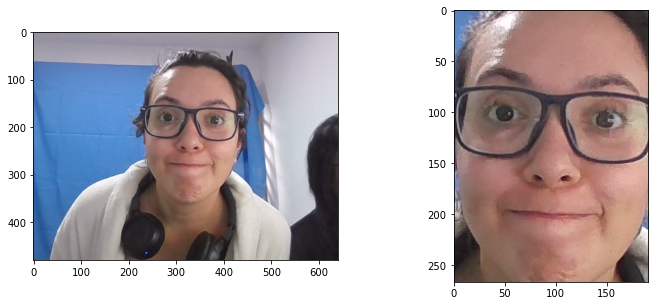

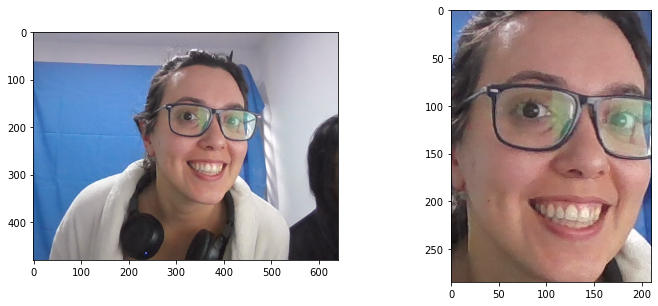

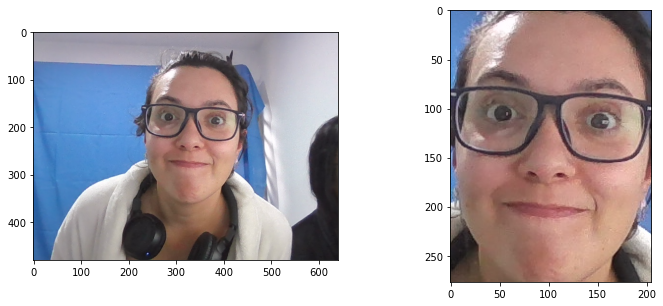

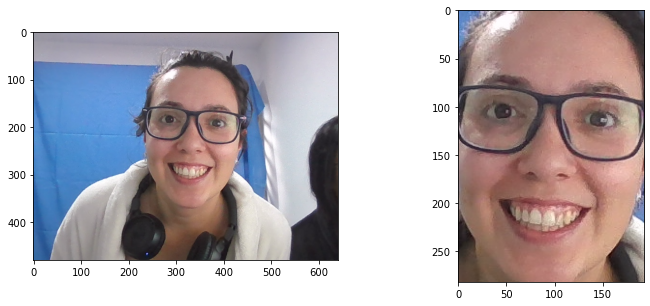

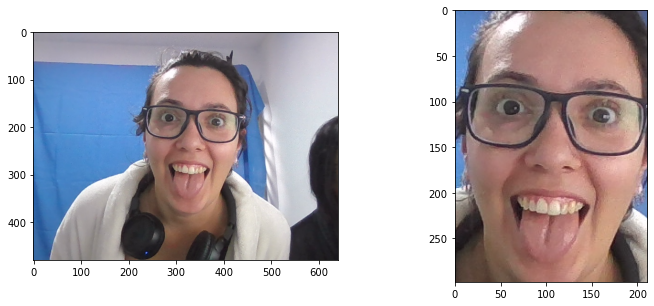

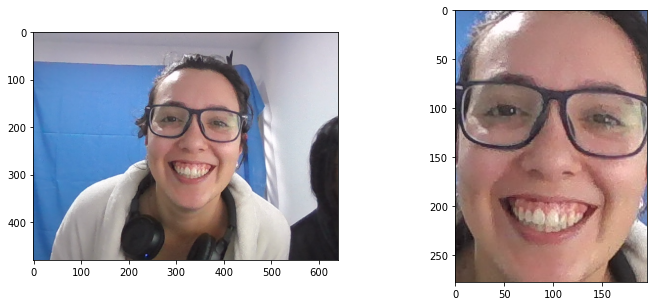

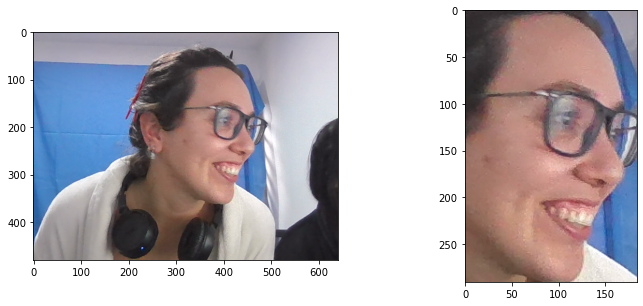

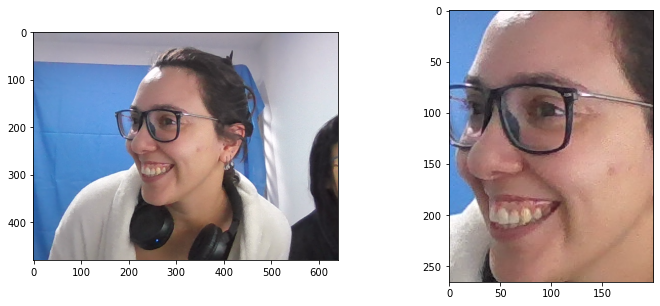

In [20]:
# Iteração em todos os usuários
for user in os.listdir(users_path):
    print(user.capitalize())
    registra_usuario(user)

# Teste com imagens nunca antes vistas!

In [21]:
def get_new_img():

    vid = cv2.VideoCapture(0) 

    ret = []
    while(True): 
        ret, frame = vid.read() 
        cv2.imshow('frame', frame) 

        if cv2.waitKey(1) & 0xFF == ord('w'):
            ret = frame
            print('1 frame capturado')
            break

        if cv2.waitKey(1) & 0xFF == ord('q'): 
            break

    vid.release() 
    cv2.destroyAllWindows() 
    
    return ret

1 frame capturado
[{'box': [233, 48, 173, 247], 'confidence': 0.9999067783355713, 'keypoints': {'left_eye': (281, 143), 'right_eye': (361, 161), 'nose': (306, 207), 'mouth_left': (272, 229), 'mouth_right': (344, 247)}}]
Identidade: Mila


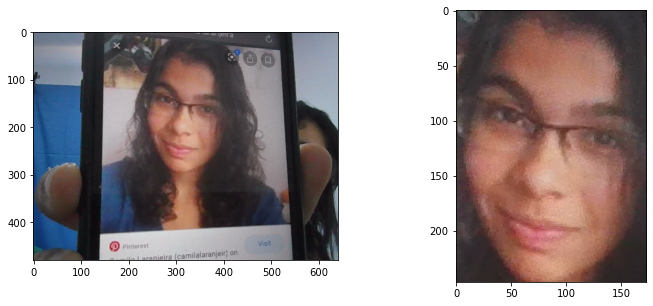

In [28]:
# Pega nova imagem
pixels = cv2.cvtColor(get_new_img(), cv2.COLOR_BGR2RGB)
feature = extract_features( pixels )

# Compara feature da nova imagem com as referências
# previamente armazenadas.
reconhecido = False
for user in os.listdir(users_path):
    
    referencia = np.load(os.path.join(users_path, user, 'referencia.npz'))
    all_features = referencia['all_feats']
    mean = referencia['mean']
    std  = referencia['std']
    
    all_dist = []
    for feat in all_features:
        all_dist.append(metric(feature, torch.from_numpy(feat) ))
        
    # Critério de identificação. Para cada usuário:
    #    calcule a média da distância da nova imagem com todas as imagens de referência
    #    compare com a média da diferença das imagens de referência entre si
    #    se a diferença estiver dentro de 1 desvio padrão, é possível que seja a pessoa!
    
    if abs( np.mean(all_dist) - mean ) < std:
        print('Identidade:', user.capitalize())
        reconhecido = True
        
if not reconhecido:
    print('Usuário não identificado')
    
